In [1]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from keras import backend as K
from keras import layers
from keras.utils.np_utils import to_categorical   
from keras import models, optimizers
from keras import metrics
from keras.utils import plot_model
from keras.datasets import cifar10

/Users/nadya-bu/au/7term/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
def get_only_classes(classes, x, y):
    index = y == classes[0]
    for clazz in classes[1:]:
        index = np.logical_or(index, y == clazz)
        
    index = index.squeeze()
        
    new_x = x[index]
    new_y = to_categorical(y[index], len(classes))
    
    p = np.random.permutation(new_x.shape[0])
    return new_x[p], new_y[p]

In [5]:
x_train10, y_train10 = get_only_classes(list(range(10)), x_train, y_train)
x_test10, y_test10 = get_only_classes(list(range(10)), x_test, y_test)
x_train10.shape, y_train10.shape, x_test10.shape, y_test10.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [6]:
x_train2, y_train2 = get_only_classes(list(range(2)), x_train, y_train)
x_test2, y_test2 = get_only_classes(list(range(2)), x_test, y_test)
x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape

((10000, 32, 32, 3), (10000, 2), (2000, 32, 32, 3), (2000, 2))

In [7]:
x_train1, y_train1 = get_only_classes(list(range(1)), x_train, y_train)
x_test1, y_test1 = get_only_classes(list(range(1)), x_test, y_test)
x_train1.shape, y_train1.shape, x_test1.shape, y_test1.shape

((5000, 32, 32, 3), (5000, 1), (1000, 32, 32, 3), (1000, 1))

In [43]:
class base_CVAE():
    def  __init__(self, batch_size, latent_size, original_dim, ans_size, step=None):
        self.batch_size = batch_size
        self.latent_size = latent_size
        self.original_dim = original_dim
        self.ans_size = ans_size
        
        pic_input = layers.Input(shape=original_dim)
        ans_input = layers.Input(shape=ans_size)
        z_input = layers.Input(shape=latent_size)
        
        self.init_pic_encoder_layers()
        self.init_encoder_layers()
        self.init_decoder_layers()
        
        z, mu = self.encode(pic_input, ans_input)
        decode = self.decode(z, ans_input)
        self.cvae = models.Model([pic_input, ans_input], decode)
        if step is not None:
            self.cvae.compile(optimizer="adam", loss=self.vae_loss, step=step)
        else:
            self.cvae.compile(optimizer="adam", loss=self.vae_loss)
        
        self.encoder = models.Model([pic_input, ans_input], [z, mu])
        
        dec_out = self.decode(z_input, ans_input)
        self.generator = models.Model([z_input, ans_input], dec_out)
        
    def history(self):
        return self.cvae.history

    def init_pic_encoder_layers(self):
        pass
    
    def init_encoder_layers(self):
        with tf.name_scope("en"):
            self.dense_en_cond = layers.Dense(512, activation='relu')
            self.dense_mu = layers.Dense(self.latent_size[0], activation='linear')
            self.dense_log_sigma = layers.Dense(self.latent_size[0], activation='linear')

    def init_decoder_layers(self):
        pass
    
    def encode_pic(self, pic_input):
        pass

    def encode(self, pic_input, ans):
        pic_enc = self.encode_pic(pic_input)
        cond_input = layers.concatenate([pic_enc, ans], axis=1)
        enc1 = self.dense_en_cond(cond_input)
        self.mu = self.dense_mu(enc1)
        self.log_sigma = self.dense_log_sigma(enc1)
    
        def eval_z(z_params):
            mu, log_sigma = z_params
            batch_dim = tf.reshape(K.shape(mu)[0], (1,))
            latent_dim = tf.reshape(tf.convert_to_tensor([self.latent_size]), (1,))
            random_shape = tf.concat([batch_dim, latent_dim], axis=0)
            eps = K.random_normal(random_shape)
            z = mu + K.exp(log_sigma / 2) * eps
            return z
           
        return layers.Lambda(eval_z)([self.mu, self.log_sigma]), self.mu

    def vae_loss(self, y_true, y_pred):
        y_true = K.reshape(y_true, (K.shape(y_true)[0], -1))
        y_pred = K.reshape(y_pred, (K.shape(y_pred)[0], -1))
        xent_loss = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
        kl_loss = 0.5 * K.sum(K.exp(self.log_sigma) + K.square(self.mu) - 1. - self.log_sigma, axis=1)
        return xent_loss + kl_loss
    
    def train(self, x_train, y_train, x_test, y_test, epochs=100):
        self.cvae.fit([x_train, y_train], x_train, batch_size=self.batch_size, epochs=epochs, 
                     validation_data=([x_test, y_test], x_test))
        
    def generate_pic(self, z, ans):
        return self.generator.predict([z, ans])
    
    def get_z(self, pic, ans):
        return self.encoder.predict([pic, ans])[0]
    
    def get_mu(self, pic, ans):
        return self.encoder.predict([pic, ans])[1]        

    def enc_dec(self, pic, ans):
        return self.generate_pic(self.get_mu(pic, ans), ans)

In [44]:
class ConvCVAE(base_CVAE):
    def  __init__(self, batch_size, latent_size, original_dim, ans_size, step=None):
        super(ConvCVAE, self).__init__(batch_size, latent_size, original_dim, ans_size, step)        
        
    def init_pic_encoder_layers(self):
        with tf.name_scope("en_pic"):
            self.en_pic_model = models.Sequential([
                layers.Conv2D(3, kernel_size=(2, 2), padding='same', activation='relu', input_shape=self.original_dim),
                layers.Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu', strides=(2, 2)),
                layers.BatchNormalization(),
                layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
                layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
                layers.Flatten()
            ])
                        
    def init_decoder_layers(self):
        with tf.name_scope("dec"):
            self.dec_model = models.Sequential([
                layers.Dense(512, activation='relu', input_shape=(self.latent_size[0] + self.ans_size[0],)),
                layers.Dense(int(x_train.shape[1]/2*x_train.shape[2]/2*x_train.shape[3]), activation='relu'),
                layers.Reshape((int(x_train.shape[1]/2), int(x_train.shape[2]/2), x_train.shape[3])),
                layers.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu'),
                layers.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu'),
                layers.BatchNormalization(),
                layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu'),
                layers.Conv2D(3, kernel_size=(2, 2), padding='valid', activation='sigmoid')
            ])
        
    def encode_pic(self, pic_input):
        return self.en_pic_model(pic_input)
        
    def decode(self, z, ans):
        z_cond = layers.concatenate([z, ans], axis=1)
        return self.dec_model(z_cond)

In [45]:
class DenseCVAE(base_CVAE):
    def  __init__(self, batch_size, latent_size, original_dim, ans_size, step=None):
        super(DenseCVAE, self).__init__(batch_size, latent_size, original_dim, ans_size, step)        

    def init_pic_encoder_layers(self):
        with tf.name_scope("en_pic"):
            self.en_pic_model = models.Sequential([
                layers.Flatten(input_shape=self.original_dim),
                layers.Dense(512, activation='relu'),
                layers.Dense(512, activation='relu')
            ])
            
    def init_decoder_layers(self):
        with tf.name_scope("dec"):
            self.dec_model = models.Sequential([
                layers.Dense(512, activation='relu', input_shape=(self.latent_size[0] + self.ans_size[0],)),
                layers.Dense(512, activation='relu'),
                layers.Dense(x_train.shape[1] * x_train.shape[2] * x_train.shape[3], activation='sigmoid'),
                layers.Reshape((x_train.shape[1], x_train.shape[2], x_train.shape[3]))
            ])
        
    def encode_pic(self, pic_input):
        return self.en_pic_model(pic_input)
    
    def decode(self, z, ans):
        z_cond = layers.concatenate([z, ans], axis=1)
        return self.dec_model(z_cond)

# DenseCVAE

In [48]:
nbatch = 320
latent_size = 64

dense_cvae = DenseCVAE(nbatch, (latent_size,), x_train10.shape[1:], y_train10.shape[1:], step=0.0005)
plot_model(dense_cvae.cvae, to_file='dense_model.png')

In [49]:
dense_cvae.train(x_train10, y_train10, x_test10, y_test10, epochs=80)

/Users/nadya-bu/au/7term/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2096: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 50000 samples, validate on 10000 samples
Epoch 1/80
50000/50000 [==============================] - 44s - loss: 1999.6365 - val_loss: 1945.9715
Epoch 2/80
50000/50000 [==============================] - 39s - loss: 1932.4125 - val_loss: 1916.5720
Epoch 3/80
50000/50000 [==============================] - 39s - loss: 1900.5263 - val_loss: 1895.7263
Epoch 4/80
50000/50000 [==============================] - 39s - loss: 1885.8837 - val_loss: 1886.6066
Epoch 5/80
50000/50000 [==============================] - 39s - loss: 1878.7465 - val_loss: 1877.2519
Epoch 6/80
50000/50000 [==============================] - 39s - loss: 1871.9320 - val_loss: 1873.9190
Epoch 7/80
50000/50000 [==============================] - 39s - loss: 1869.2466 - val_loss: 1878.8163
Epoch 8/80
50000/50000 [==============================] - 39s - loss: 1866.4147 - val_loss: 1868.4209
Epoch 9/80
50000/50000 [==============================] - 39s - loss: 1863.5674 - val_loss: 1868.2372
Epoch 10/80
50000/50000 [=======

50000/50000 [==============================] - 39s - loss: 1828.3202 - val_loss: 1835.9278


Training history


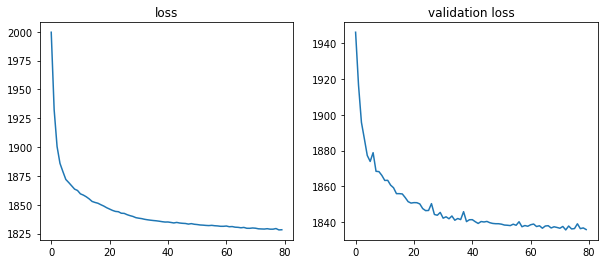

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Training history")
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(dense_cvae.history().history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(dense_cvae.history().history['val_loss'])
ax2.set_title('validation loss')

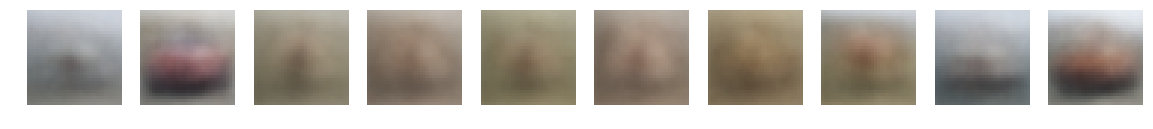

In [53]:
from keras.utils import np_utils

pic_size = 32

z_sample = np.random.rand(1, latent_size) # random 

plt.figure(figsize=(20, 2))
for i in range(10):
    c = np_utils.to_categorical(i, y_train10.shape[1])
    x_decoded = dense_cvae.generate_pic(z_sample, c)
    pic = x_decoded[0]

    plt.subplot(1, y_train10.shape[1], i + 1)
    plt.axis('off')
    plt.imshow(pic)
plt.show()

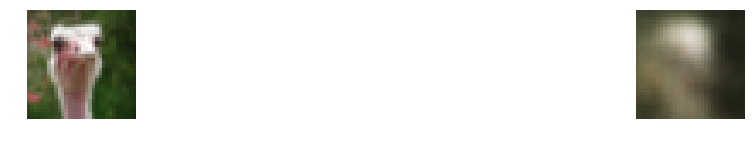

In [54]:
x_decoded = dense_cvae.enc_dec(x_train10[:1], y_train10[:1])

plt.figure(figsize=(20, 2))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(x_train10[0])

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(x_decoded[0])

plt.show()

# ConvCVAE

In [55]:
nbatch = 320
latent_size = 64

conv_cvae = ConvCVAE(nbatch, (latent_size,), x_train10.shape[1:], y_train10.shape[1:])
plot_model(conv_cvae.cvae, to_file='conv_model.png')

In [56]:
conv_cvae.train(x_train10, y_train10, x_test10, y_test10, epochs=80)

Train on 50000 samples, validate on 10000 samples
Epoch 1/80
50000/50000 [==============================] - 270s - loss: 2019.0533 - val_loss: 2169.7377
Epoch 2/80
50000/50000 [==============================] - 258s - loss: 1897.0527 - val_loss: 2053.7062
Epoch 3/80
50000/50000 [==============================] - 258s - loss: 1873.6249 - val_loss: 1951.1322
Epoch 4/80
50000/50000 [==============================] - 259s - loss: 1863.4490 - val_loss: 1877.9144
Epoch 5/80
50000/50000 [==============================] - 258s - loss: 1857.3113 - val_loss: 1861.4554
Epoch 6/80
50000/50000 [==============================] - 262s - loss: 1852.1062 - val_loss: 1852.2813
Epoch 7/80
50000/50000 [==============================] - 266s - loss: 1843.5767 - val_loss: 1849.8716
Epoch 8/80
50000/50000 [==============================] - 243s - loss: 1838.8011 - val_loss: 1851.4557
Epoch 9/80
50000/50000 [==============================] - 242s - loss: 1836.4642 - val_loss: 1839.6481
Epoch 10/80
50000/50000

KeyboardInterrupt: 

Training history


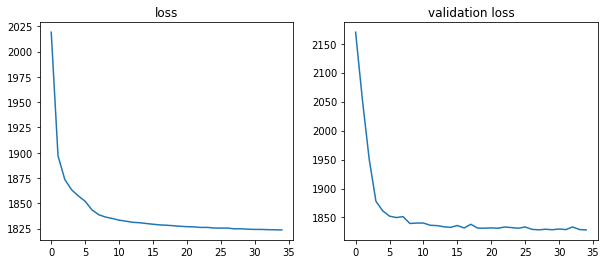

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Training history")
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(conv_cvae.history().history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(conv_cvae.history().history['val_loss'])
ax2.set_title('validation loss')

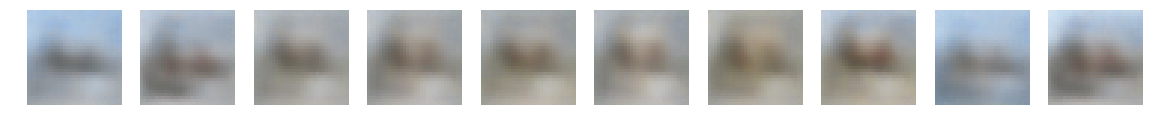

In [58]:
from keras.utils import np_utils
pic_size = 32

z_sample = np.random.rand(1, latent_size) # random 

plt.figure(figsize=(20, 2))
for i in range(10):
    c = np_utils.to_categorical(i, y_train10.shape[1])
    x_decoded = conv_cvae.generate_pic(z_sample, c)
    pic = x_decoded[0].reshape(pic_size, pic_size, 3)

    plt.subplot(1, y_train10.shape[1], i + 1)
    plt.axis('off')
    plt.imshow(pic)
plt.show()

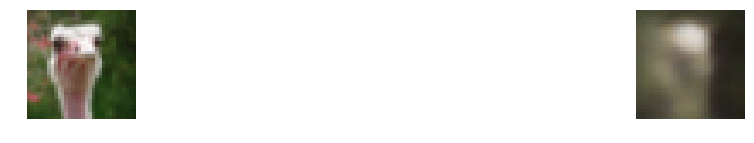

In [59]:
x_decoded = conv_cvae.enc_dec(x_train10[:1], y_train10[:1])

plt.figure(figsize=(20, 2))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(x_train10[0])

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(x_decoded[0])

plt.show()

# Dense CVAE on MNIST

In [34]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

x_train, y_train = mnist.train.images, mnist.train.labels
x_test, y_test = mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [53]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
dense_cvae = DenseCVAE(nbatch, (latent_size,), x_train.shape[1:], y_train.shape[1:])

In [54]:
dense_cvae.train(x_train, y_train, x_test, y_test)

Train on 55000 samples, validate on 10000 samples
Epoch 1/100
55000/55000 [==============================] - 27s - loss: 157.9547 - val_loss: 123.8569
Epoch 2/100
55000/55000 [==============================] - 25s - loss: 117.8575 - val_loss: 112.5329
Epoch 3/100
55000/55000 [==============================] - 26s - loss: 110.5610 - val_loss: 107.8058
Epoch 4/100
55000/55000 [==============================] - 26s - loss: 106.9492 - val_loss: 104.7613
Epoch 5/100
55000/55000 [==============================] - 26s - loss: 104.4549 - val_loss: 103.1350
Epoch 6/100
55000/55000 [==============================] - 26s - loss: 102.7975 - val_loss: 101.3555
Epoch 7/100
55000/55000 [==============================] - 26s - loss: 101.5357 - val_loss: 100.5839
Epoch 8/100
55000/55000 [==============================] - 26s - loss: 100.5443 - val_loss: 100.1194
Epoch 9/100
55000/55000 [==============================] - 27s - loss: 99.7767 - val_loss: 99.6552
Epoch 10/100
55000/55000 [=================

KeyboardInterrupt: 

Training history


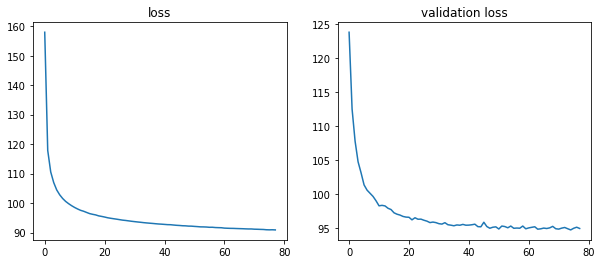

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Training history")
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(dense_cvae.history().history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(dense_cvae.history().history['val_loss'])
ax2.set_title('validation loss')

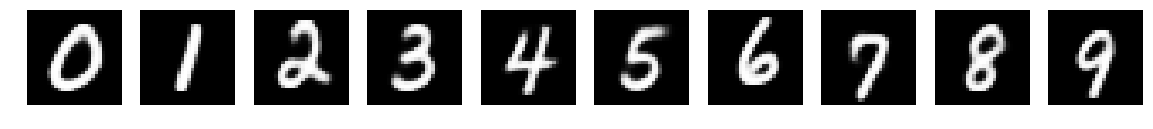

In [56]:
from keras.utils import np_utils

pic_size = 28

z_sample = np.random.rand(1, latent_size) # random 

plt.figure(figsize=(20, 2))
for i in range(10):
    c = np_utils.to_categorical(i, y_train.shape[1])
    x_decoded = dense_cvae.generate_pic(z_sample, c)
    digit = x_decoded[0].reshape(pic_size, pic_size)

    plt.subplot(1, y_train.shape[1], i + 1)
    plt.axis('off')
    plt.imshow(digit, cmap='Greys_r')
plt.show()

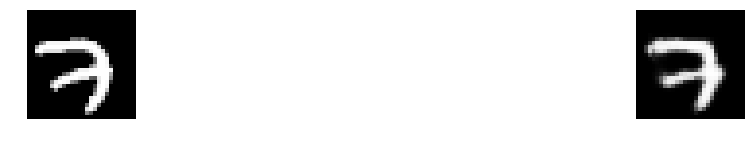

In [57]:
x_decoded = dense_cvae.enc_dec(x_train[:1], y_train[:1])

plt.figure(figsize=(20, 2))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(x_train[0].reshape(pic_size, pic_size), cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(x_decoded[0].reshape(pic_size, pic_size), cmap='Greys_r')

plt.show()